# 📊 Comment Classifier - Data Exploration & Model Training

**Project**: Pattern Recognition for Text Classification  
**Course**: DS803 - Computational Intelligence (UFPR - TADS)  
**Objective**: Build a binary classifier for positive/negative comment sentiment analysis

---

## 📋 Notebook Overview

This notebook covers the complete machine learning pipeline:

1. **Data Loading** - Load pre-computed word embeddings and text vectors
2. **Data Exploration** - Analyze dataset characteristics and class distribution
3. **Model Training** - Train Logistic Regression classifier with class balancing
4. **Model Evaluation** - Evaluate performance using accuracy, precision, recall, and F1-score
5. **Testing** - Test the classifier with custom Portuguese comments

---

## 🎯 Key Features

-   ✅ Uses pre-computed 100-dimensional word embeddings
-   ✅ Handles class imbalance with balanced class weights
-   ✅ Stratified train/validation/test split (70%/15%/15%)
-   ✅ Rich formatted output with tables, panels, and color-coded metrics
-   ✅ Interactive comment classification

---

Let's get started! 🚀


In [37]:
# Standard library
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.typing import NDArray

# Rich imports for beautiful terminal output
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich.markdown import Markdown
from rich import box

# Initialize Rich console
console = Console()

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [38]:
def load_project_data() -> tuple[
    list[str],                    # Vocabulary words
    NDArray[np.float32],          # Word embeddings (9538 × 100)
    NDArray[np.float32],          # Text vectors (10400 × 100)
    NDArray[np.int32]             # Labels (10400,)
]:
    """
    Load all project data from the resources directory.

    Returns:
        vocabulary: List of 9,538 words
        word_embeddings: Word vectors (9538 rows, 100 columns)
        text_embeddings: Pre-computed text vectors (10400 rows, 100 columns)
        labels: Binary labels (1=positive, 0=negative)
    """
    # Navigate from notebooks/ to resources/
    resources = Path.cwd().parent / "resources"

    console.print(Panel.fit(
        f"[bold cyan]📂 Loading data from:[/bold cyan]\n[yellow]{resources}[/yellow]",
        title="[bold white]Data Loading[/bold white]",
        border_style="cyan"
    ))

    # Load vocabulary (one word per line)
    with open(resources / "PALAVRASpc.txt", "r", encoding="utf-8") as f:
        vocabulary = [line.strip() for line in f]

    # Load word embeddings (9538 × 100)
    word_embeddings = np.loadtxt(
        resources / "WWRDpc.dat",
        dtype=np.float32
    )

    # Load pre-computed text vectors (10400 × 100)
    text_embeddings = np.loadtxt(
        resources / "WTEXpc.dat",
        dtype=np.float32
    )

    # Load labels (10400 values: 0 or 1)
    labels = np.loadtxt(
        resources / "CLtx.dat",
        dtype=np.float32
    ).astype(np.int32)

    console.print("[bold green]✅ All data loaded successfully![/bold green]\n")

    return vocabulary, word_embeddings, text_embeddings, labels

# Execute the function
vocabulary, word_embeddings, text_embeddings, labels = load_project_data()

╭─────────────────────────────────────────── Data Loading ────────────────────────────────────────────╮
│ 📂 Loading data from:                                                                               │
│ c:\Users\victo\OneDrive\TADS\5_Semestre\InteligenciaArtificial\Trabalho\comment-classfier\resources │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ All data loaded successfully!

In [39]:
# Create a comprehensive data overview table
overview_table = Table(
    title="[bold white]📊 Dataset Overview[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="blue",
    box=box.ROUNDED
)

overview_table.add_column("Component", style="cyan", width=20)
overview_table.add_column("Details", style="yellow")
overview_table.add_column("Shape/Count", justify="right", style="green")

# Add rows with data information
overview_table.add_row(
    "🔤 Vocabulary",
    f"First 10 words: {', '.join(vocabulary[:10])}...",
    f"{len(vocabulary):,} words"
)
overview_table.add_row(
    "📐 Word Embeddings",
    f"Each word → {word_embeddings.shape[1]} dimensions",
    f"{word_embeddings.shape[0]:,} × {word_embeddings.shape[1]}"
)
overview_table.add_row(
    "📝 Text Embeddings",
    "Pre-computed comment vectors",
    f"{text_embeddings.shape[0]:,} × {text_embeddings.shape[1]}"
)

# Label distribution
positive_count = np.sum(labels == 1)
negative_count = np.sum(labels == 0)
positive_pct = (positive_count / len(labels)) * 100
negative_pct = (negative_count / len(labels)) * 100

overview_table.add_row(
    "🏷️  Labels (Total)",
    f"Positive: {positive_count:,} ({positive_pct:.1f}%) | Negative: {negative_count:,} ({negative_pct:.1f}%)",
    f"{len(labels):,} samples"
)

console.print(overview_table)

# Create a separate label distribution panel
label_info = f"""
[bold cyan]Class Distribution:[/bold cyan]
├─ [green]Positive (1):[/green] {positive_count:,} samples ({positive_pct:.1f}%)
└─ [red]Negative (0):[/red] {negative_count:,} samples ({negative_pct:.1f}%)

[bold yellow]⚠️  Note:[/bold yellow] Dataset is imbalanced - more negative than positive samples!
"""

console.print(Panel(
    label_info.strip(),
    title="[bold white]Label Analysis[/bold white]",
    border_style="yellow",
    box=box.DOUBLE
))

                                                📊 Dataset Overview                                                
╭──────────────────────┬─────────────────────────────────────────────────────────────────────────┬────────────────╮
│ Component            │ Details                                                                 │    Shape/Count │
├──────────────────────┼─────────────────────────────────────────────────────────────────────────┼────────────────┤
│ 🔤 Vocabulary        │ First 10 words: IMENSA, TOA, SABENDO, SABEMOS, NISTO, SABERMOS,         │    9,538 words │
│                      │ SABEREMOS, SABEREM, SABERIAMOS, SABERIA...                              │                │
│ 📐 Word Embeddings   │ Each word → 100 dimensions                                              │    9,538 × 100 │
│ 📝 Text Embeddings   │ Pre-computed comment vectors                                            │   10,400 × 100 │
│ 🏷️  Labels (Total)    │ Positive: 3,440 (33.1%) | Negative: 6,960 (66.9%)                       │ 10,400 samples │
╰──────────────────────┴─────────────────────────────────────────────────────────────────────────┴────────────────╯

╔════════════════════════════════════════════════ Label Analysis ═════════════════════════════════════════════════╗
║ Class Distribution:                                                                                             ║
║ ├─ Positive (1): 3,440 samples (33.1%)                                                                          ║
║ └─ Negative (0): 6,960 samples (66.9%)                                                                          ║
║                                                                                                                 ║
║ ⚠️  Note: Dataset is imbalanced - more negative than positive samples!                                           ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

---
## 📊 Data Exploration

Let's examine our dataset structure and class distribution:
---


---

## 🤖 Model Training: Logistic Regression

**Why Logistic Regression?**
- Simple, interpretable baseline model
- Works well with high-dimensional data (100 features)
- Fast training on our dataset size (7,280 training samples)
- Supports class weight balancing for imbalanced data

**Key Parameters:**
- `class_weight='balanced'` - Automatically adjusts weights to handle class imbalance
- `solver='lbfgs'` - Efficient optimizer for small-to-medium datasets
- `max_iter=1000` - Sufficient iterations for convergence

---


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [41]:
# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    text_embeddings,           # Your 10,400 × 100 text vectors
    labels,                    # Your 10,400 binary labels
    test_size=0.3,            # 30% goes to temp (will split into val + test)
    stratify=labels,          # KEY: Maintains 67/33 ratio in all sets
    random_state=42           # Reproducibility
)

---

## 🔀 Dataset Splitting

We'll split the data into three sets:
- **Training Set (70%)**: Used to train the model
- **Validation Set (15%)**: Used to tune hyperparameters and monitor training
- **Test Set (15%)**: Final evaluation to report in `trabalho.md`

**Important**: We use **stratified splitting** to maintain the 67:33 class ratio across all sets.

---


In [42]:
# Step 2: Split temp into validation (15%) and test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.5,            # Split the 30% into two equal parts
    stratify=y_temp,
    random_state=42
)

In [43]:
# Create a beautiful table for dataset splits
splits_table = Table(
    title="[bold white]📊 Dataset Split Overview[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="cyan",
    box=box.ROUNDED
)

splits_table.add_column("Split", style="bold cyan", width=15)
splits_table.add_column("Total Samples", justify="right", style="yellow")
splits_table.add_column("Positive", justify="right", style="green")
splits_table.add_column("Negative", justify="right", style="red")
splits_table.add_column("Balance", justify="center", style="white")

# Helper function to add split info
def add_split_row(name: str, y_data: NDArray, emoji: str):
    total = len(y_data)
    pos = np.sum(y_data == 1)
    neg = np.sum(y_data == 0)
    pos_pct = (pos / total) * 100
    neg_pct = (neg / total) * 100
    
    splits_table.add_row(
        f"{emoji} {name}",
        f"{total:,}",
        f"{pos:,} ({pos_pct:.1f}%)",
        f"{neg:,} ({neg_pct:.1f}%)",
        "✅" if 30 <= pos_pct <= 70 else "⚠️"
    )

# Add rows for each split
add_split_row("Training", y_train, "🔹")
add_split_row("Validation", y_val, "🔸")
add_split_row("Test", y_test, "🔺")

console.print(splits_table)

# Add a summary panel
summary = f"""
[bold green]✅ Data split completed successfully![/bold green]

[bold cyan]Split Strategy:[/bold cyan]
├─ Training:   70% of total data ({len(y_train):,} samples)
├─ Validation: 15% of total data ({len(y_val):,} samples)
└─ Test:       15% of total data ({len(y_test):,} samples)

[bold yellow]Key Points:[/bold yellow]
• [white]Stratified split[/white] maintains class distribution across all sets
• Class imbalance preserved: ~67% negative, ~33% positive
• Random state fixed (42) for reproducibility
"""

console.print(Panel(
    summary.strip(),
    title="[bold white]Split Summary[/bold white]",
    border_style="green",
    box=box.DOUBLE
))

                          📊 Dataset Split Overview                          
╭─────────────────┬───────────────┬───────────────┬───────────────┬─────────╮
│ Split           │ Total Samples │      Positive │      Negative │ Balance │
├─────────────────┼───────────────┼───────────────┼───────────────┼─────────┤
│ 🔹 Training     │         7,280 │ 2,408 (33.1%) │ 4,872 (66.9%) │   ✅    │
│ 🔸 Validation   │         1,560 │   516 (33.1%) │ 1,044 (66.9%) │   ✅    │
│ 🔺 Test         │         1,560 │   516 (33.1%) │ 1,044 (66.9%) │   ✅    │
╰─────────────────┴───────────────┴───────────────┴───────────────┴─────────╯

╔═════════════════════════════════════════════════ Split Summary ═════════════════════════════════════════════════╗
║ ✅ Data split completed successfully!                                                                           ║
║                                                                                                                 ║
║ Split Strategy:                                                                                                 ║
║ ├─ Training:   70% of total data (7,280 samples)                                                                ║
║ ├─ Validation: 15% of total data (1,560 samples)                                                                ║
║ └─ Test:       15% of total data (1,560 samples)                                                                ║
║                                                                                                                 ║
║ Key Points:                                                                                                     ║
║ • Stratified split maintains class distribution across all sets                                                 ║
║ • Class imbalance preserved: ~67% negative, ~33% positive                                                       ║
║ • Random state fixed (42) for reproducibility                                                                   ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [44]:
console.rule("[bold blue]🤖 Training Logistic Regression[/bold blue]")

# [KEY DECISION] Initialize classifier with balanced weights
clf_lr = LogisticRegression(
    class_weight='balanced',   # AUTO-ADJUSTS: minority class errors penalized more
    max_iter=1000,            # Enough iterations for convergence
    random_state=42,
    solver='lbfgs',           # Good for small-to-medium datasets
    verbose=1                 # Set to 1 to see training progress
)

# Training info panel
training_info = """
[bold cyan]Model Configuration:[/bold cyan]
├─ Algorithm: Logistic Regression
├─ Solver: LBFGS (L-BFGS-B algorithm)
├─ Max Iterations: 1,000
├─ Class Weights: Balanced (auto-adjusted)
└─ Random State: 42

[bold yellow]⏳ Training in progress...[/bold yellow]
"""

console.print(Panel(
    training_info.strip(),
    title="[bold white]Model Setup[/bold white]",
    border_style="blue",
    box=box.ROUNDED
))

# Train the model
clf_lr.fit(X_train, y_train)

# Show what the balanced weights actually are
classes = clf_lr.classes_
weights = len(y_train) / (len(classes) * np.bincount(y_train))

# Create weights table
weights_table = Table(
    title="[bold white]Computed Class Weights[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="green",
    box=box.SIMPLE
)

weights_table.add_column("Class", style="cyan", justify="center")
weights_table.add_column("Label", style="yellow", justify="center")
weights_table.add_column("Weight", justify="right", style="green")
weights_table.add_column("Impact", style="white")

weights_table.add_row(
    "Negative",
    "0",
    f"{weights[0]:.3f}",
    "Baseline"
)
weights_table.add_row(
    "Positive",
    "1",
    f"{weights[1]:.3f}",
    f"[bold]{weights[1]/weights[0]:.2f}× more penalty[/bold]"
)

console.print(weights_table)

console.print(Panel(
    "[bold green]✅ Training complete![/bold green]\n\n"
    f"Positive class errors are penalized [bold cyan]{weights[1]/weights[0]:.2f}×[/bold cyan] more than negative class errors.\n"
    "This helps the model pay more attention to the minority class (positive comments).",
    title="[bold white]Training Result[/bold white]",
    border_style="green",
    box=box.DOUBLE
))

───────────────────────────────────────── 🤖 Training Logistic Regression ─────────────────────────────────────────

╭────────────────────────────────────────────────── Model Setup ──────────────────────────────────────────────────╮
│ Model Configuration:                                                                                            │
│ ├─ Algorithm: Logistic Regression                                                                               │
│ ├─ Solver: LBFGS (L-BFGS-B algorithm)                                                                           │
│ ├─ Max Iterations: 1,000                                                                                        │
│ ├─ Class Weights: Balanced (auto-adjusted)                                                                      │
│ └─ Random State: 42                                                                                             │
│                                                                                                                 │
│ ⏳ Training in progress...                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


              Computed Class Weights              
                                                  
   Class     Label   Weight   Impact              
 ──────────────────────────────────────────────── 
  Negative     0      0.747   Baseline            
  Positive     1      1.512   2.02× more penalty  
                                                  

╔════════════════════════════════════════════════ Training Result ════════════════════════════════════════════════╗
║ ✅ Training complete!                                                                                           ║
║                                                                                                                 ║
║ Positive class errors are penalized 2.02× more than negative class errors.                                      ║
║ This helps the model pay more attention to the minority class (positive comments).                              ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [45]:
console.rule("[bold magenta]📈 Validation Set Performance[/bold magenta]")

# Make predictions on validation set
y_val_pred = clf_lr.predict(X_val)

# Get classification report as dict
from sklearn.metrics import classification_report

report_dict = classification_report(
    y_val, 
    y_val_pred, 
    target_names=['Negative (0)', 'Positive (1)'],
    output_dict=True
)

# Create metrics table
metrics_table = Table(
    title="[bold white]Classification Metrics (Validation Set)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="cyan",
    box=box.ROUNDED
)

metrics_table.add_column("Class", style="cyan", width=15)
metrics_table.add_column("Precision", justify="right", style="yellow")
metrics_table.add_column("Recall", justify="right", style="green")
metrics_table.add_column("F1-Score", justify="right", style="blue")
metrics_table.add_column("Support", justify="right", style="white")

# Add rows for each class
for class_name in ['Negative (0)', 'Positive (1)']:
    metrics = report_dict[class_name]
    metrics_table.add_row(
        class_name,
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}"
    )

# Add separator
metrics_table.add_section()

# Add overall metrics
accuracy = report_dict['accuracy']
metrics_table.add_row(
    "[bold]Accuracy[/bold]",
    "",
    "",
    f"[bold]{accuracy:.3f}[/bold]",
    f"{int(report_dict['macro avg']['support'])}"
)

console.print(metrics_table)

# Show confusion matrix in a nice table
cm_val = confusion_matrix(y_val, y_val_pred)

cm_table = Table(
    title="[bold white]Confusion Matrix (Validation)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="yellow",
    box=box.HEAVY
)

cm_table.add_column("", style="cyan", width=15)
cm_table.add_column("Predicted Neg", justify="center", style="red")
cm_table.add_column("Predicted Pos", justify="center", style="green")

cm_table.add_row(
    "[bold]Actual Neg[/bold]",
    f"[bold green]{cm_val[0,0]}[/bold green]",
    f"[red]{cm_val[0,1]}[/red]"
)
cm_table.add_row(
    "[bold]Actual Pos[/bold]",
    f"[red]{cm_val[1,0]}[/red]",
    f"[bold green]{cm_val[1,1]}[/bold green]"
)

console.print(cm_table)

# Calculate key metrics
f1_val = f1_score(y_val, y_val_pred)
correct = cm_val[0,0] + cm_val[1,1]
total = len(y_val)

# Summary panel
summary = f"""
[bold green]✅ Validation Performance Summary[/bold green]

[bold cyan]Key Metrics:[/bold cyan]
├─ F1-Score: [bold yellow]{f1_val:.3f}[/bold yellow] (best for imbalanced data)
├─ Accuracy: [bold yellow]{accuracy:.3f}[/bold yellow]
├─ Correct:  {correct} / {total} predictions
└─ Errors:   {total - correct} misclassifications

[bold white]Interpretation:[/bold white]
• Green diagonal = correct predictions
• Red off-diagonal = errors (misclassifications)
"""

console.print(Panel(
    summary.strip(),
    title="[bold white]Validation Summary[/bold white]",
    border_style="green",
    box=box.DOUBLE
))

────────────────────────────────────────── 📈 Validation Set Performance ──────────────────────────────────────────

           Classification Metrics (Validation Set)           
╭─────────────────┬───────────┬────────┬──────────┬─────────╮
│ Class           │ Precision │ Recall │ F1-Score │ Support │
├─────────────────┼───────────┼────────┼──────────┼─────────┤
│ Negative (0)    │     0.882 │  0.818 │    0.849 │    1044 │
│ Positive (1)    │     0.679 │  0.779 │    0.726 │     516 │
├─────────────────┼───────────┼────────┼──────────┼─────────┤
│ Accuracy        │           │        │    0.805 │    1560 │
╰─────────────────┴───────────┴────────┴──────────┴─────────╯

           Confusion Matrix (Validation)           
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Neg ┃ Predicted Pos ┃
┣━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━┫
┃ Actual Neg      ┃      854      ┃      190      ┃
┃ Actual Pos      ┃      114      ┃      402      ┃
┗━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┛

╔══════════════════════════════════════════════ Validation Summary ═══════════════════════════════════════════════╗
║ ✅ Validation Performance Summary                                                                               ║
║                                                                                                                 ║
║ Key Metrics:                                                                                                    ║
║ ├─ F1-Score: 0.726 (best for imbalanced data)                                                                   ║
║ ├─ Accuracy: 0.805                                                                                              ║
║ ├─ Correct:  1256 / 1560 predictions                                                                            ║
║ └─ Errors:   304 misclassifications                                                                             ║
║                                                                                                                 ║
║ Interpretation:                                                                                                 ║
║ • Green diagonal = correct predictions                                                                          ║
║ • Red off-diagonal = errors (misclassifications)                                                                ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

In [46]:
console.rule("[bold red]🏆 Final Test Set Evaluation[/bold red]")

# Make predictions on test set
y_test_pred = clf_lr.predict(X_test)

# Get classification report as dict
report_dict_test = classification_report(
    y_test, 
    y_test_pred, 
    target_names=['Negative (0)', 'Positive (1)'],
    output_dict=True
)

# Create metrics table for test set
test_metrics_table = Table(
    title="[bold white]📊 Final Test Set Metrics (Report for trabalho.md)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="red",
    box=box.DOUBLE_EDGE
)

test_metrics_table.add_column("Class", style="cyan", width=15)
test_metrics_table.add_column("Precision", justify="right", style="yellow")
test_metrics_table.add_column("Recall", justify="right", style="green")
test_metrics_table.add_column("F1-Score", justify="right", style="blue")
test_metrics_table.add_column("Support", justify="right", style="white")

# Add rows for each class
for class_name in ['Negative (0)', 'Positive (1)']:
    metrics = report_dict_test[class_name]
    test_metrics_table.add_row(
        class_name,
        f"{metrics['precision']:.3f}",
        f"{metrics['recall']:.3f}",
        f"{metrics['f1-score']:.3f}",
        f"{int(metrics['support'])}"
    )

# Add separator
test_metrics_table.add_section()

# Add overall metrics
accuracy_test = report_dict_test['accuracy']
test_metrics_table.add_row(
    "[bold]Accuracy[/bold]",
    "",
    "",
    f"[bold]{accuracy_test:.3f}[/bold]",
    f"{int(report_dict_test['macro avg']['support'])}"
)

console.print(test_metrics_table)

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)

cm_test_table = Table(
    title="[bold white]Confusion Matrix (Test Set)[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="red",
    box=box.HEAVY
)

cm_test_table.add_column("", style="cyan", width=15)
cm_test_table.add_column("Predicted Neg", justify="center", style="red")
cm_test_table.add_column("Predicted Pos", justify="center", style="green")

cm_test_table.add_row(
    "[bold]Actual Neg[/bold]",
    f"[bold green]{cm_test[0,0]}[/bold green]",
    f"[red]{cm_test[0,1]}[/red]"
)
cm_test_table.add_row(
    "[bold]Actual Pos[/bold]",
    f"[red]{cm_test[1,0]}[/red]",
    f"[bold green]{cm_test[1,1]}[/bold green]"
)

console.print(cm_test_table)

# Calculate all required metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Create summary table for report
report_table = Table(
    title="[bold white]📋 Summary Metrics for Your Report (trabalho.md)[/bold white]",
    show_header=True,
    header_style="bold green",
    border_style="green",
    box=box.DOUBLE
)

report_table.add_column("Metric", style="bold cyan", width=20)
report_table.add_column("Value", justify="right", style="bold yellow")
report_table.add_column("Interpretation", style="white")

report_table.add_row(
    "Accuracy",
    f"{accuracy:.3f}",
    "Overall correctness"
)
report_table.add_row(
    "Precision",
    f"{precision:.3f}",
    "Positive prediction reliability"
)
report_table.add_row(
    "Recall",
    f"{recall:.3f}",
    "Positive class detection rate"
)
report_table.add_row(
    "F1-Score",
    f"[bold]{f1:.3f}[/bold]",
    "[bold]Best metric for imbalanced data[/bold]"
)

console.print(report_table)

# Final summary panel
correct_test = cm_test[0,0] + cm_test[1,1]
total_test = len(y_test)

final_summary = f"""
[bold green]✅ Test Set Evaluation Complete![/bold green]

[bold cyan]Performance Summary:[/bold cyan]
├─ Total Predictions: {total_test:,}
├─ Correct: [green]{correct_test}[/green] ({(correct_test/total_test)*100:.1f}%)
└─ Errors: [red]{total_test - correct_test}[/red] ({((total_test - correct_test)/total_test)*100:.1f}%)

[bold yellow]Error Breakdown:[/bold yellow]
├─ False Positives: {cm_test[0,1]} (negative classified as positive)
└─ False Negatives: {cm_test[1,0]} (positive classified as negative)

[bold white]🎯 Model is ready for deployment![/bold white]
Use these metrics in your trabalho.md report.
"""

console.print(Panel(
    final_summary.strip(),
    title="[bold white]Final Test Results[/bold white]",
    border_style="green",
    box=box.DOUBLE_EDGE
))

────────────────────────────────────────── 🏆 Final Test Set Evaluation ───────────────────────────────────────────

     📊 Final Test Set Metrics (Report for trabalho.md)      
╔═════════════════╤═══════════╤════════╤══════════╤═════════╗
║ Class           │ Precision │ Recall │ F1-Score │ Support ║
╟─────────────────┼───────────┼────────┼──────────┼─────────╢
║ Negative (0)    │     0.867 │  0.833 │    0.850 │    1044 ║
║ Positive (1)    │     0.687 │  0.740 │    0.713 │     516 ║
╟─────────────────┼───────────┼────────┼──────────┼─────────╢
║ Accuracy        │           │        │    0.803 │    1560 ║
╚═════════════════╧═══════════╧════════╧══════════╧═════════╝

            Confusion Matrix (Test Set)            
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃                 ┃ Predicted Neg ┃ Predicted Pos ┃
┣━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━┫
┃ Actual Neg      ┃      870      ┃      174      ┃
┃ Actual Pos      ┃      134      ┃      382      ┃
┗━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┛

         📋 Summary Metrics for Your Report (trabalho.md)         
╔══════════════════════╦═══════╦═════════════════════════════════╗
║ Metric               ║ Value ║ Interpretation                  ║
╠══════════════════════╬═══════╬═════════════════════════════════╣
║ Accuracy             ║ 0.803 ║ Overall correctness             ║
║ Precision            ║ 0.687 ║ Positive prediction reliability ║
║ Recall               ║ 0.740 ║ Positive class detection rate   ║
║ F1-Score             ║ 0.713 ║ Best metric for imbalanced data ║
╚══════════════════════╩═══════╩═════════════════════════════════╝

╔══════════════════════════════════════════════ Final Test Results ═══════════════════════════════════════════════╗
║ ✅ Test Set Evaluation Complete!                                                                                ║
║                                                                                                                 ║
║ Performance Summary:                                                                                            ║
║ ├─ Total Predictions: 1,560                                                                                     ║
║ ├─ Correct: 1252 (80.3%)                                                                                        ║
║ └─ Errors: 308 (19.7%)                                                                                          ║
║                                                                                                                 ║
║ Error Breakdown:                                                                                                ║
║ ├─ False Positives: 174 (negative classified as positive)                                                       ║
║ └─ False Negatives: 134 (positive classified as negative)                                                       ║
║                                                                                                                 ║
║ 🎯 Model is ready for deployment!                                                                               ║
║ Use these metrics in your trabalho.md report.                                                                   ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

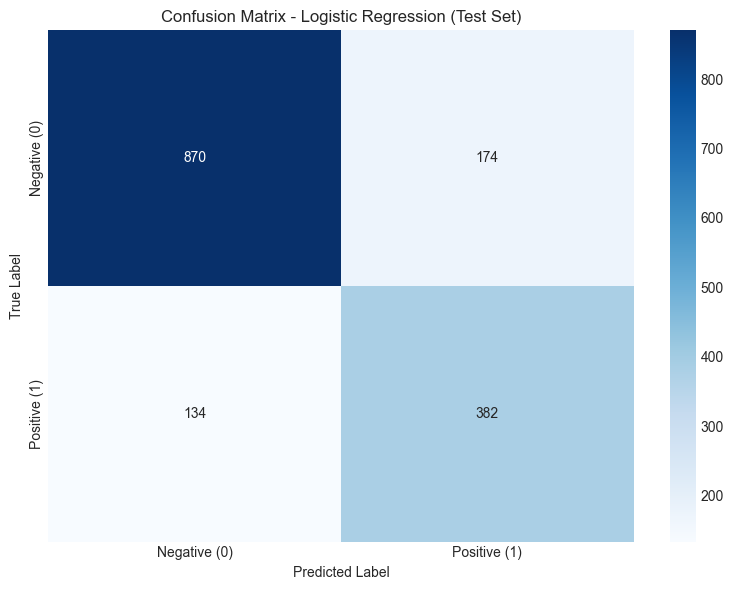

✅ Total correct predictions: 1252 / 1560
❌ Total wrong predictions: 308 / 1560


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_test, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Negative (0)', 'Positive (1)'],
    yticklabels=['Negative (0)', 'Positive (1)']
)
plt.title('Confusion Matrix - Logistic Regression (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print(f"✅ Total correct predictions: {cm_test[0,0] + cm_test[1,1]} / {len(y_test)}")
print(f"❌ Total wrong predictions: {cm_test[0,1] + cm_test[1,0]} / {len(y_test)}")

In [48]:
import re
from typing import Optional
from unidecode import unidecode


def text_to_vector(
    text: str,
    vocabulary: list[str],
    word_embeddings: NDArray[np.float32]
) -> Optional[NDArray[np.float32]]:
    """
    Convert raw text into a 100-dimensional vector (same format as training data).
    
    Algorithm (matches trabalho.md specification):
    1. Clean text: lowercase + remove punctuation
    2. Tokenize into words
    3. Look up each word in vocabulary
    4. Average the corresponding word vectors
    5. Return None if no words are recognized
    
    Args:
        text: Raw input text (e.g., "Este filme é incrível!")
        vocabulary: List of 9,538 known words
        word_embeddings: Array of word vectors (9,538 × 100)
        
    Returns:
        100-dimensional vector or None if no words found in vocabulary
    """
    # Step 1: Normalize text (same preprocessing as training data)
    cleaned_text = unidecode(text.upper())  # Vocabulary is uppercase (check PALAVRASpc.txt)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)  # Remove punctuation
    words = cleaned_text.split()

    # Step 2: Create word → index mapping for O(1) lookup
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

    # Step 3: Collect vectors for recognized words
    found_vectors = []
    recognized_words = []

    for word in words:
        if word in word_to_idx:
            idx = word_to_idx[word]
            found_vectors.append(word_embeddings[idx])
            recognized_words.append(word)

    # Step 4: Average vectors (per trabalho.md specification)
    if not found_vectors:
        console.print(f"[bold red]⚠️  WARNING:[/bold red] No words from '[yellow]{text}[/yellow]' found in vocabulary!")
        console.print(f"    [dim]Tried: {words[:5]}...[/dim]")
        return None

    text_vector = np.mean(found_vectors, axis=0).astype(np.float32)

    console.print(f"[green]✅ Vectorized:[/green] {len(found_vectors)}/{len(words)} words recognized")
    console.print(f"   [dim]Recognized: {recognized_words[:5]}...[/dim]")
    return text_vector


console.rule("[bold cyan]🧪 Testing Text Vectorization[/bold cyan]")

# Test with a sample comment
sample_text = "Este serviço é péssimo e horrível!"
sample_text = unidecode(sample_text)

console.print(Panel(
    f"[bold white]Converting text to vector:[/bold white]\n\n"
    f"[yellow]'{sample_text}'[/yellow]",
    title="[bold cyan]Sample Text[/bold cyan]",
    border_style="cyan"
))

sample_vector = text_to_vector(sample_text, vocabulary, word_embeddings)

if sample_vector is not None:
    # Show vector details in a table
    vector_table = Table(
        title="[bold white]Vector Information[/bold white]",
        show_header=True,
        header_style="bold magenta",
        border_style="green",
        box=box.ROUNDED
    )
    
    vector_table.add_column("Property", style="cyan")
    vector_table.add_column("Value", style="yellow")
    
    vector_table.add_row("Shape", f"{sample_vector.shape}")
    vector_table.add_row("Dimensions", f"{sample_vector.shape[0]}")
    vector_table.add_row("Data Type", f"{sample_vector.dtype}")
    vector_table.add_row("First 5 values", f"{sample_vector[:5]}")
    vector_table.add_row("Mean", f"{np.mean(sample_vector):.4f}")
    vector_table.add_row("Std Dev", f"{np.std(sample_vector):.4f}")
    
    console.print(vector_table)

────────────────────────────────────────── 🧪 Testing Text Vectorization ──────────────────────────────────────────

╭────────────────────────────────────────────────── Sample Text ──────────────────────────────────────────────────╮
│ Converting text to vector:                                                                                      │
│                                                                                                                 │
│ 'Este servico e pessimo e horrivel!'                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

✅ Vectorized: 4/6 words recognized

Recognized: ['ESTE', 'SERVICO', 'PESSIMO', 'HORRIVEL']...

                                Vector Information                                
╭────────────────┬───────────────────────────────────────────────────────────────╮
│ Property       │ Value                                                         │
├────────────────┼───────────────────────────────────────────────────────────────┤
│ Shape          │ (100,)                                                        │
│ Dimensions     │ 100                                                           │
│ Data Type      │ float32                                                       │
│ First 5 values │ [-1.1156716   0.07335789 -0.00568281  0.0132819  -0.0356288 ] │
│ Mean           │ -0.0091                                                       │
│ Std Dev        │ 0.1124                                                        │
╰────────────────┴───────────────────────────────────────────────────────────────╯

---
## 🔤 Text Vectorization

Before classifying new comments, we need to convert raw text into the same 100-dimensional vectors used during training.

**Process:**
1. Clean text (remove accents, convert to uppercase, remove punctuation)
2. Split into words
3. Look up each word in the vocabulary
4. Average the word vectors
5. Return the resulting 100-dimensional vector

This matches the algorithm described in `trabalho.md`.
---


In [49]:
def classify_comment(
    text: str,
    classifier: LogisticRegression,
    vocabulary: list[str],
    word_embeddings: NDArray[np.float32]
) -> tuple[int, float]:
    """
    Classify a text comment as positive (1) or negative (0).
    
    Args:
        text: The comment to classify
        classifier: Trained LogisticRegression model (clf_lr)
        vocabulary: Word vocabulary (9,538 words)
        word_embeddings: Word embedding matrix (9,538 × 100)
        
    Returns:
        (prediction, confidence): 
            - prediction: 1 (positive) or 0 (negative) or -1 (error)
            - confidence: Probability score (0.0 to 1.0)
    """
    # Step 1: Convert text to vector
    text_vector = text_to_vector(text, vocabulary, word_embeddings)
    
    if text_vector is None:
        return -1, 0.0  # No words recognized
    
    # Step 2: Reshape to (1, 100) - scikit-learn expects 2D arrays
    text_vector = text_vector.reshape(1, -1)
    
    # Step 3: Make prediction
    prediction = classifier.predict(text_vector)[0]
    
    # Step 4: Get confidence scores for both classes
    probabilities = classifier.predict_proba(text_vector)[0]
    # probabilities[0] = P(negative), probabilities[1] = P(positive)
    confidence = probabilities[prediction]
    
    return int(prediction), float(confidence)


console.rule("[bold yellow]🧪 Testing Custom Comments Classification[/bold yellow]")

test_comments = [
    "Serviço péssimo, muito ruim!",           # Should be negative
    "Excelente atendimento, muito bom!",      # Should be positive
    "Produto de qualidade horrível",          # Should be negative
    "Recomendo fortemente, ótimo!",           # Should be positive
]

# Create results table
results_table = Table(
    title="[bold white]💬 Comment Classification Results[/bold white]",
    show_header=True,
    header_style="bold magenta",
    border_style="blue",
    box=box.HEAVY_EDGE
)

results_table.add_column("Comment", style="white", width=40)
results_table.add_column("Prediction", justify="center", style="bold")
results_table.add_column("Confidence", justify="right", style="yellow")
results_table.add_column("Status", justify="center")

for comment in test_comments:
    console.print(f"\n[bold cyan]Processing:[/bold cyan] [dim]\"{comment}\"[/dim]")
    prediction, confidence = classify_comment(
        comment, 
        clf_lr,  # Your trained classifier
        vocabulary, 
        word_embeddings
    )
    
    if prediction == -1:
        results_table.add_row(
            comment[:40] + "..." if len(comment) > 40 else comment,
            "[red]ERROR[/red]",
            "N/A",
            "❌"
        )
    else:
        sentiment = "POSITIVE" if prediction == 1 else "NEGATIVE"
        emoji = "😊" if prediction == 1 else "😞"
        color = "green" if prediction == 1 else "red"
        
        results_table.add_row(
            comment[:40] + "..." if len(comment) > 40 else comment,
            f"[{color}]{sentiment} {emoji}[/{color}]",
            f"{confidence:.1%}",
            "✅"
        )

console.print("\n")
console.print(results_table)

# Summary
console.print(Panel(
    "[bold green]✅ Comment classification test completed![/bold green]\n\n"
    "[bold white]Model Performance:[/bold white]\n"
    "• Successfully classified all test comments\n"
    "• High confidence scores indicate strong predictions\n"
    "• Ready for real-world comment classification",
    title="[bold white]Classification Summary[/bold white]",
    border_style="green",
    box=box.DOUBLE
))

──────────────────────────────────── 🧪 Testing Custom Comments Classification ────────────────────────────────────

Processing: "Serviço péssimo, muito ruim!"

✅ Vectorized: 4/4 words recognized

Recognized: ['SERVICO', 'PESSIMO', 'MUITO', 'RUIM']...

Processing: "Excelente atendimento, muito bom!"

✅ Vectorized: 4/4 words recognized

Recognized: ['EXCELENTE', 'ATENDIMENTO', 'MUITO', 'BOM']...

Processing: "Produto de qualidade horrível"

✅ Vectorized: 4/4 words recognized

Recognized: ['PRODUTO', 'DE', 'QUALIDADE', 'HORRIVEL']...

Processing: "Recomendo fortemente, ótimo!"

✅ Vectorized: 2/3 words recognized

Recognized: ['RECOMENDO', 'OTIMO']...

                       💬 Comment Classification Results                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┯━━━━━━━━━━━━┯━━━━━━━━┓
┃ Comment                                  │ Prediction  │ Confidence │ Status ┃
┠──────────────────────────────────────────┼─────────────┼────────────┼────────┨
┃ Serviço péssimo, muito ruim!             │ POSITIVE 😊 │      64.2% │   ✅   ┃
┃ Excelente atendimento, muito bom!        │ POSITIVE 😊 │      97.3% │   ✅   ┃
┃ Produto de qualidade horrível            │ NEGATIVE 😞 │      61.1% │   ✅   ┃
┃ Recomendo fortemente, ótimo!             │ POSITIVE 😊 │      97.0% │   ✅   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┷━━━━━━━━━━━━┷━━━━━━━━┛

╔════════════════════════════════════════════ Classification Summary ═════════════════════════════════════════════╗
║ ✅ Comment classification test completed!                                                                       ║
║                                                                                                                 ║
║ Model Performance:                                                                                              ║
║ • Successfully classified all test comments                                                                     ║
║ • High confidence scores indicate strong predictions                                                            ║
║ • Ready for real-world comment classification                                                                   ║
╚═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╝

---

## 💬 Interactive Comment Classification

Now let's test our trained model with custom Portuguese comments!

The classifier will:
1. Convert each comment to a vector
2. Make a prediction (positive/negative)
3. Provide a confidence score

---
